# DeepEurovoc

The goal of this experiment is to predict Eurovoc codes based on expression abstracts published by the PO. 

The model used in this notebook is identical to the 1-dimensional convolutional neural network described in the Keras blog article https://blog.keras.io/using-pre-trained-word-embeddings-in-a-keras-model.html. It uses pre-trained GloVe word embeddings for text classification.

The input is retrieved from PO's public SPARQL endpoint, available at http://publications.europa.eu/webapi/rdf/sparql. The following query does the job:

The input data is stored in data.csv. Before loading the data, we import the modules we will need throughout this notebook.

In [1]:
import pandas as pd
import numpy as np
import os
import sys
import xml.etree.ElementTree as ET
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet

import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Dense, Input, GlobalMaxPooling1D, Flatten
from keras.layers import Conv1D, MaxPooling1D, Embedding
from keras.models import Model
from keras.initializers import Constant

from sklearn.preprocessing import MultiLabelBinarizer

/Users/sebastianthelen/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Definition of some global variables used in this notebook:

In [2]:
CLEANUP_DATA = False 
MAX_NUM_WORDS = 20000 # size of vocabulary
EMBEDDING_DIM = 100 # dimension of GloVe word embeddings
MAX_SEQUENCE_LENGTH = 1000 # truncate abstracts after MAX_SEQUENCE_LENGTH words

Load the data and get some numbers...

In [3]:
data_df = pd.read_csv("data.csv")
print(data_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35472 entries, 0 to 35471
Data columns (total 3 columns):
exp         35472 non-null object
abstract    35472 non-null object
concepts    35472 non-null object
dtypes: object(3)
memory usage: 831.5+ KB
None


We define a function that helps us extract the abstracts as plain text from the XMLLiterals returned by Virtuoso, removes all non-English words including stop words, and performs lemmatization on the filtered words.

In [4]:
def cleanup_abstract(xmlstring):
    #import ipdb; ipdb.set_trace()
    xmlstring = xmlstring.replace('""', '"')
    text = None
    try: 
        tree = ET.ElementTree(ET.fromstring(xmlstring))
        xpath_result = tree.findall(".//description")
        text = xpath_result[0].text
    except:
        text = xmlstring
    # remove stopwords and punctuation. lower case everything
    stop_words = set(stopwords.words('english'))
    tokens = word_tokenize(text)
    tokens = [w.lower() for w in tokens if not w in stop_words and w.isalpha() and wordnet.synsets(w)]
    # lemmatize
    lemma = WordNetLemmatizer()
    final_tokens = []
    for word in tokens:
        final_tokens.append(lemma.lemmatize(word))
    ret = " ".join(final_tokens)
    return ret

Cleaning the data involves two steps:

1\. clean the abstracts 

2\. transform the ";" separated eurovoc codes in the concepts column into lists of eurovoc codes. 

In [5]:
if CLEANUP_DATA:
    data_df["cleaned_abstract"] = data_df["abstract"].apply(cleanup_abstract)
    data_df["concept_list"] = data_df["concepts"].apply(lambda x: [c for c in x.split(";")])
    data_df.drop(["abstract"], axis=1)
    data_df.to_pickle("data_df.pkl")

The next line loads the cleaned up data directly from file instead of computing it everytime the notebook is executed.

In [6]:
data_df = pd.read_pickle("data_df.pkl")
print(data_df['cleaned_abstract'][:5])
print(data_df['concept_list'][:5])

0    at institute reference material measurement di...
1    statistic focus describes preliminary result b...
2    short document aim provide summary main issue ...
3    briefing note intended provide european parlia...
4    exterior de la sus la de para de en la en para...
Name: cleaned_abstract, dtype: object
0    [http://eurovoc.europa.eu/1158, http://eurovoc...
1    [http://eurovoc.europa.eu/4258, http://eurovoc...
2    [http://eurovoc.europa.eu/1759, http://eurovoc...
3    [http://eurovoc.europa.eu/1159, http://eurovoc...
4    [http://eurovoc.europa.eu/2783, http://eurovoc...
Name: concept_list, dtype: object


We must convert the data set labels to numbers so that they can be processed by Keras. The appraoch is described in https://www.pyimagesearch.com/2018/05/07/multi-label-classification-with-keras/.

In [7]:
labels = data_df["concept_list"].tolist()

mlb = MultiLabelBinarizer()
labels = mlb.fit_transform(labels)
 
# loop over each of the possible class labels and show them
for (i, label) in enumerate(mlb.classes_):
	print("{}. {}".format(i + 1, label))

1. http://eurovoc.europa.eu/10
2. http://eurovoc.europa.eu/1000
3. http://eurovoc.europa.eu/1002
4. http://eurovoc.europa.eu/1004
5. http://eurovoc.europa.eu/1005
6. http://eurovoc.europa.eu/1007
7. http://eurovoc.europa.eu/1008
8. http://eurovoc.europa.eu/1009
9. http://eurovoc.europa.eu/101
10. http://eurovoc.europa.eu/1011
11. http://eurovoc.europa.eu/1012
12. http://eurovoc.europa.eu/1013
13. http://eurovoc.europa.eu/1014
14. http://eurovoc.europa.eu/1015
15. http://eurovoc.europa.eu/1016
16. http://eurovoc.europa.eu/1017
17. http://eurovoc.europa.eu/1018
18. http://eurovoc.europa.eu/1019
19. http://eurovoc.europa.eu/102
20. http://eurovoc.europa.eu/1021
21. http://eurovoc.europa.eu/1023
22. http://eurovoc.europa.eu/1024
23. http://eurovoc.europa.eu/1025
24. http://eurovoc.europa.eu/1026
25. http://eurovoc.europa.eu/103
26. http://eurovoc.europa.eu/1030
27. http://eurovoc.europa.eu/1035
28. http://eurovoc.europa.eu/1036
29. http://eurovoc.europa.eu/1037
30. http://eurovoc.europa.eu

1447. http://eurovoc.europa.eu/2739
1448. http://eurovoc.europa.eu/274
1449. http://eurovoc.europa.eu/2740
1450. http://eurovoc.europa.eu/2742
1451. http://eurovoc.europa.eu/2743
1452. http://eurovoc.europa.eu/2744
1453. http://eurovoc.europa.eu/2745
1454. http://eurovoc.europa.eu/2746
1455. http://eurovoc.europa.eu/2747
1456. http://eurovoc.europa.eu/2748
1457. http://eurovoc.europa.eu/2749
1458. http://eurovoc.europa.eu/275
1459. http://eurovoc.europa.eu/2750
1460. http://eurovoc.europa.eu/2751
1461. http://eurovoc.europa.eu/2753
1462. http://eurovoc.europa.eu/2754
1463. http://eurovoc.europa.eu/2757
1464. http://eurovoc.europa.eu/2758
1465. http://eurovoc.europa.eu/2759
1466. http://eurovoc.europa.eu/276
1467. http://eurovoc.europa.eu/2761
1468. http://eurovoc.europa.eu/2762
1469. http://eurovoc.europa.eu/2763
1470. http://eurovoc.europa.eu/2764
1471. http://eurovoc.europa.eu/2765
1472. http://eurovoc.europa.eu/2766
1473. http://eurovoc.europa.eu/2767
1474. http://eurovoc.europa.eu/

2447. http://eurovoc.europa.eu/3951
2448. http://eurovoc.europa.eu/3952
2449. http://eurovoc.europa.eu/3953
2450. http://eurovoc.europa.eu/3954
2451. http://eurovoc.europa.eu/3955
2452. http://eurovoc.europa.eu/3956
2453. http://eurovoc.europa.eu/3957
2454. http://eurovoc.europa.eu/3959
2455. http://eurovoc.europa.eu/396
2456. http://eurovoc.europa.eu/3960
2457. http://eurovoc.europa.eu/3961
2458. http://eurovoc.europa.eu/3962
2459. http://eurovoc.europa.eu/3963
2460. http://eurovoc.europa.eu/3965
2461. http://eurovoc.europa.eu/3966
2462. http://eurovoc.europa.eu/3967
2463. http://eurovoc.europa.eu/3968
2464. http://eurovoc.europa.eu/3969
2465. http://eurovoc.europa.eu/397
2466. http://eurovoc.europa.eu/3970
2467. http://eurovoc.europa.eu/3973
2468. http://eurovoc.europa.eu/3974
2469. http://eurovoc.europa.eu/398
2470. http://eurovoc.europa.eu/3980
2471. http://eurovoc.europa.eu/3983
2472. http://eurovoc.europa.eu/3984
2473. http://eurovoc.europa.eu/3985
2474. http://eurovoc.europa.eu/

3446. http://eurovoc.europa.eu/5236
3447. http://eurovoc.europa.eu/5237
3448. http://eurovoc.europa.eu/5238
3449. http://eurovoc.europa.eu/5239
3450. http://eurovoc.europa.eu/524
3451. http://eurovoc.europa.eu/5240
3452. http://eurovoc.europa.eu/5241
3453. http://eurovoc.europa.eu/5242
3454. http://eurovoc.europa.eu/5243
3455. http://eurovoc.europa.eu/5246
3456. http://eurovoc.europa.eu/525
3457. http://eurovoc.europa.eu/5251
3458. http://eurovoc.europa.eu/5252
3459. http://eurovoc.europa.eu/5253
3460. http://eurovoc.europa.eu/5254
3461. http://eurovoc.europa.eu/5255
3462. http://eurovoc.europa.eu/5256
3463. http://eurovoc.europa.eu/5257
3464. http://eurovoc.europa.eu/5258
3465. http://eurovoc.europa.eu/5259
3466. http://eurovoc.europa.eu/526
3467. http://eurovoc.europa.eu/5260
3468. http://eurovoc.europa.eu/5261
3469. http://eurovoc.europa.eu/5262
3470. http://eurovoc.europa.eu/5263
3471. http://eurovoc.europa.eu/5264
3472. http://eurovoc.europa.eu/5265
3473. http://eurovoc.europa.eu/

4446. http://eurovoc.europa.eu/6623
4447. http://eurovoc.europa.eu/6624
4448. http://eurovoc.europa.eu/6625
4449. http://eurovoc.europa.eu/6626
4450. http://eurovoc.europa.eu/6627
4451. http://eurovoc.europa.eu/6628
4452. http://eurovoc.europa.eu/663
4453. http://eurovoc.europa.eu/664
4454. http://eurovoc.europa.eu/665
4455. http://eurovoc.europa.eu/666
4456. http://eurovoc.europa.eu/667
4457. http://eurovoc.europa.eu/668
4458. http://eurovoc.europa.eu/669
4459. http://eurovoc.europa.eu/6697
4460. http://eurovoc.europa.eu/6699
4461. http://eurovoc.europa.eu/67
4462. http://eurovoc.europa.eu/670
4463. http://eurovoc.europa.eu/6700
4464. http://eurovoc.europa.eu/6703
4465. http://eurovoc.europa.eu/6704
4466. http://eurovoc.europa.eu/6705
4467. http://eurovoc.europa.eu/6706
4468. http://eurovoc.europa.eu/6708
4469. http://eurovoc.europa.eu/6709
4470. http://eurovoc.europa.eu/671
4471. http://eurovoc.europa.eu/6710
4472. http://eurovoc.europa.eu/6711
4473. http://eurovoc.europa.eu/6713
447

In [8]:
#labels2 = [["a","b","c"],["c","d","e"]]

#mlb2 = MultiLabelBinarizer()
#labels2 = mlb2.fit_transform(labels2)

#print(list(mlb2.classes_))
#print(mlb2.transform([["a","b"],["c","d","e"]]))
#print(mlb2.inverse_transform(mlb2.transform([["a","b"],["c","d","e"]])))

#y = data_df["concept_list"].tolist()[0]
#print("y = ", y)
#print("len(y) = ", len(y))
#print("mlb.transform([y]) = ", mlb.transform([y]))
#print("len(mlb.transform([y])[0]) = ", len(mlb.transform([y])[0]))
#print("mlb.transform([y])[0].tolist().count(1) = ", mlb.transform([y])[0].tolist().count(1))
#print("mlb.inverse_transform(mlb.transform([y])) = ", mlb.inverse_transform(mlb.transform([y])))
#print("len(mlb.classes_) = ", len(mlb.classes_))

A small test to make sure that we are really getting multi-label vectors and not just one-hot vectors.

In [9]:
print("Labels of the 2nd training example: " + str(mlb.inverse_transform(np.array([labels[1]]))))

Labels of the 2nd training example: [('http://eurovoc.europa.eu/4258', 'http://eurovoc.europa.eu/4671', 'http://eurovoc.europa.eu/6371')]


Next we need to tranform the input into an array of numbers:

In [10]:
data = data_df["cleaned_abstract"].tolist()

#print(len(data[0]))
#print(type(data[0]))
#print(data[0])
tokenizer = Tokenizer(nb_words=MAX_NUM_WORDS)
tokenizer.fit_on_texts(data)
sequences = tokenizer.texts_to_sequences(data)

#print(len(sequences[0]))
#print(sequences[0])

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
#labels = to_categorical(np.asarray(labels))
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)


/Users/sebastianthelen/anaconda3/lib/python3.6/site-packages/keras/preprocessing/text.py:172: UserWarning: The `nb_words` argument in `Tokenizer` has been renamed `num_words`.
  warnings.warn('The `nb_words` argument in `Tokenizer` '


Found 22343 unique tokens.
Shape of data tensor: (35472, 1000)
Shape of label tensor: (35472, 5032)


Split data into training data and test data.

In [11]:
VALIDATION_SPLIT = 0.2

# split the data into a training set and a validation set
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]
num_validation_samples = int(VALIDATION_SPLIT * data.shape[0])
print(num_validation_samples)
trainX = data[:-num_validation_samples]
trainY = labels[:-num_validation_samples]
testX = data[-num_validation_samples:]
testY = labels[-num_validation_samples:]

print(data.shape)
print(labels.shape)
print(trainX.shape)
print(trainY.shape)
print(testX.shape)
print(testY.shape)

7094
(35472, 1000)
(35472, 5032)
(28378, 1000)
(28378, 5032)
(7094, 1000)
(7094, 5032)


Load the pre-computed GloVe word embeddings from file and create an embeddings_index:

In [12]:
embeddings_index = {}
with open(os.path.join('glove.6B', 'glove.6B.100d.txt'), 'r') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


Use word_index and embedding_index to compute the embedding_matrix. embedding_matrix is  a matrix storing the embedded_vector for each word in the data set. 

In [13]:
num_words = min(MAX_NUM_WORDS, len(word_index) + 1)
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in word_index.items():
    if i >= MAX_NUM_WORDS:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
    #else:
    #    print("Not not in embedding index: " + word)

Build an Keras embedding_layer. Note that trainable=false, i.e., weights are not getting updated. 

In [14]:
embedding_layer = Embedding(num_words,
                            EMBEDDING_DIM,
                            embeddings_initializer=Constant(embedding_matrix),
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)

Let's define the 1D convolutional model.

In [22]:
from keras.layers import Dropout

sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)
x = Conv1D(128, 5, activation='relu')(embedded_sequences)
x = MaxPooling1D(5)(x)
x = Dropout(0.25)(x)
x = Conv1D(128, 5, activation='relu')(x)
x = MaxPooling1D(5)(x)
x = Dropout(0.25)(x)
x = Conv1D(128, 5, activation='relu')(x)
x = MaxPooling1D(35)(x)  # global max pooling
x = Dropout(0.25)(x)
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
preds = Dense(labels.shape[1], activation='sigmoid')(x)

model = Model(sequence_input, preds)
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['acc'])

Now the model needs to be trained.

In [23]:
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 1000)              0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 1000, 100)         2000000   
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 996, 128)          64128     
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 199, 128)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 199, 128)          0         
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 195, 128)          82048     
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, 39, 128)           0         
__________

In [20]:
history = model.fit(trainX, trainY, validation_data=(testX, testY),
          epochs=1, batch_size=128)


Train on 28378 samples, validate on 7094 samples
Epoch 1/1
12544/28378 [============>.................] - ETA: 2:44 - loss: 0.0664 - acc: 0.9830

KeyboardInterrupt: 

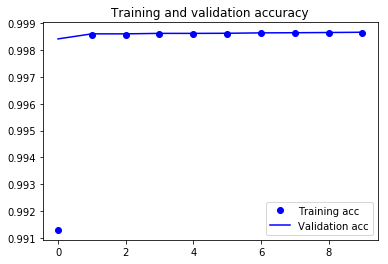

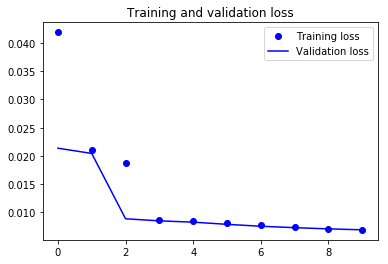

In [21]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [24]:
print(data_df['cleaned_abstract'].tolist()[:2])
ex = data_df['cleaned_abstract'][0]
seq = tokenizer.texts_to_sequences(ex)
seq = pad_sequences(seq, maxlen=MAX_SEQUENCE_LENGTH)
print("len(ex) = ", len(ex))
print("seq.shape = ", seq.shape)
print("Example: " + str(ex) + "\n")
print("Sequence: " + str(seq) + "\n")
prediction = model.predict(np.array(seq))[0]
prediction[prediction>=0.25] = 1
prediction[prediction<0.25] = 0
print("Prediction: " + str(prediction))
print(type(prediction))
print(prediction.shape)

mlb.inverse_transform(np.array([prediction]))

#proba = model.predict(np.array(seq))[0]
#idxs = np.argsort(proba)[::-1][:2]



['at institute reference material measurement dismantling campaign obsolete installation glove box run main goal create le waste possible extensive contamination check decontaminating necessary glove box decontamination possible here necessary document stage dismantling process purpose report learn experience campaign gave ability make estimate future radioactive waste classic waste expected dismantled installation', 'statistic focus describes preliminary result balance payment current account detailed figure current account main component good service income current transfer presented together analysis development geographical breakdown flow main partner a detailed breakdown trade service also included']
len(ex) =  416
seq.shape =  (416, 1000)
Example: at institute reference material measurement dismantling campaign obsolete installation glove box run main goal create le waste possible extensive contamination check decontaminating necessary glove box decontamination possible here nece

[('http://eurovoc.europa.eu/1528',
  'http://eurovoc.europa.eu/4060',
  'http://eurovoc.europa.eu/5491')]